In [2]:
import scanpy as sc
import os
import shutil
import time
from scipy.sparse import csc_matrix
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
from scipy import sparse
from scipy.sparse import issparse

sc.settings.set_figure_params(dpi=80, facecolor='white')

def BasicFilter(adata,qc_min_genes=200,qc_min_cells=0,plot_show=False):
    """
    do basic filtering
    :param adata: adata object
    :param qc_min_genes: filter cell, which expresses genes number less than this paramters
    :param qc_min_cells: filter gene, which expressed in cells number less than this paramters
    :param plot_show: show the plot not not
    :return: adata object, and plot stored in figures sub-folder
    """

    sc.pl.highest_expr_genes(adata, n_top=20, save='_20TopGene.png' ,show=plot_show)

    print('Before filter, %d Cells, %d Genes' % (adata.shape))
    sc.pp.filter_cells(adata, min_genes=qc_min_genes)
    sc.pp.filter_genes(adata, min_cells=qc_min_cells)
    print('After filter, %d Cells, %d Genes' % (adata.shape))

    return adata

def QC_Metrics_info(adata,doublet_removal=False,plot_show=False):
    """
    display quality control plot, for QC parameters selection
    :param adata: adata object
    :param plot_show: show the plot not not
    :return: adata object, and plot stored in figures sub-folder
    """
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True,save='_QC_guide.png',show=plot_show)

    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',save='_pct_counts_mt.png',show=plot_show)
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',save='_n_genes_by_counts.png',show=plot_show)
    return adata

def save_adata_h5ad(adata,out_path='None',shrink_to_sparse=False):
    """
    save adata with h5ad format
    :param adata: adata object to save
    :param out_path: path of saved adata
    :return: None
    """
    if shrink_to_sparse:

        if adata.raw is None:
            # convert adata X only
            adata.X = sparse.csr_matrix(adata.X)  
        else:
            # convert adata X
            adata.X = sparse.csr_matrix(adata.X)
            # convert adata.raw X
            adata_raw_tmp=adata.raw.to_adata()
            adata_raw_tmp.X=sparse.csr_matrix(adata_raw_tmp.X)
            adata.raw=adata_raw_tmp

        adata.write_h5ad(out_path)
    else:
        adata.write_h5ad(out_path)
    print('Current data saved')

def read_adata_h5ad(h5ad_path='None',expand_from_sparse=False):
    """
    read exist adata h5ad file
    :param h5ad_path: path of h5ad file
    :return: adata object
    """
    if expand_from_sparse:
        # recover full matrix from sparse matrix
        adata = sc.read_h5ad(h5ad_path)
        if adata.raw is None:
            # convert adata X only
            adata.X = sparse.csr_matrix.toarray(adata.X)  
        else:
            # convert adata X
            adata.X = sparse.csr_matrix.toarray(adata.X)  
            # convert adata.raw X
            adata_raw_tmp=adata.raw.to_adata()
            adata_raw_tmp.X=sparse.csr_matrix.toarray(adata_raw_tmp.X)
            adata.raw=adata_raw_tmp
    else:
        adata = sc.read_h5ad(h5ad_path)
    return adata

def main_gene_selection(X_df, gene_list):
    """
    Describe:
        rebuild the input adata to select target genes encode protein 
    Parameters:
        adata->`~anndata.AnnData` object: adata with var index_name by gene symbol
        gene_list->list: wanted target gene 
    Returns:
        adata_new->`~anndata.AnnData` object
        to_fill_columns->list: zero padding gene
    """
    to_fill_columns = list(set(gene_list) - set(X_df.columns))
    padding_df = pd.DataFrame(np.zeros((X_df.shape[0], len(to_fill_columns))), 
                              columns=to_fill_columns, 
                              index=X_df.index)
    X_df = pd.DataFrame(np.concatenate([df.values for df in [X_df, padding_df]], axis=1), 
                        index=X_df.index, 
                        columns=list(X_df.columns) + list(padding_df.columns))
    X_df = X_df[gene_list]
    
    var = pd.DataFrame(index=X_df.columns)
    var['mask'] = [1 if i in to_fill_columns else 0 for i in list(var.index)]
    return X_df, to_fill_columns,var

In [2]:
def print_filenames(folder_path):
    """
    Prints the names of all files in a given folder.

    Args:
        folder_path: Path to the folder you want to list files from.
    """
    filenames = []
    for filename in os.listdir(folder_path):
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(folder_path, filename)):
            filenames.append(filename)
    return filenames

# Example usage:
folder_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/colorectal_cancer/GSE161277'

for i in sorted(print_filenames(folder_path)):
    print(i)

In [9]:
path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/GSM6047623_P1_T_R_I'
adata = sc.read_10x_mtx(path) # read from 10x file

X_df= pd.DataFrame(sparse.csr_matrix.toarray(adata.X),index=adata.obs.index.tolist(),columns=adata.var.index.tolist()) # read from csv file
gene_list_df = pd.read_csv('../OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])
X_df, to_fill_columns, var = main_gene_selection(X_df, gene_list)
adata_uni = sc.AnnData(X_df)
adata_uni.obs = adata.obs
adata_uni.uns = adata.uns

adata_uni = BasicFilter(adata_uni,qc_min_genes=200,qc_min_cells=0) # filter cell and gene by lower limit
adata_uni = QC_Metrics_info(adata_uni)

save_path = './GSM4653863_HC1/demo.h5ad'
save_adata_h5ad(adata_uni,save_path)

In [28]:
# Define paths
matrix_data_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/matrix_data'
cleaned_data_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data'

# Ensure cleaned_data directory exists
os.makedirs(cleaned_data_path, exist_ok=True)

# Rename files in each subfolder
for folder in os.listdir(matrix_data_path):
    folder_path = os.path.join(matrix_data_path, folder)
    
    if os.path.isdir(folder_path):
        print(f'Renaming files in folder: {folder}')
        
        # File mapping based on current names
        files = os.listdir(folder_path)
        file_map = {
            'barcodes.tsv.gz': None,
            'features.tsv.gz': None,
            'matrix.mtx.gz': None
        }
        
        # Map current file names to new names
        for file in files:
            if 'barcodes' in file:
                file_map['barcodes.tsv.gz'] = file
            elif 'features' in file:
                file_map['features.tsv.gz'] = file
            elif 'matrix' in file:
                file_map['matrix.mtx.gz'] = file
        
        # Rename the files
        for new_name, old_name in file_map.items():
            if old_name:
                old_file_path = os.path.join(folder_path, old_name)
                new_file_path = os.path.join(folder_path, new_name)
                os.rename(old_file_path, new_file_path)
                print(f'Renamed {old_name} to {new_name}')


Renaming files in folder: GSM6047629_P2_T_R_M
Renamed GSM6047629_P2_T_R_M_barcodes.tsv.gz to barcodes.tsv.gz
Renamed GSM6047629_P2_T_R_M_features.tsv.gz to features.tsv.gz
Renamed GSM6047629_P2_T_R_M_matrix.mtx.gz to matrix.mtx.gz
Renaming files in folder: GSM6047635_P8_T2_R_M
Renamed GSM6047635_P8_T2_R_M_barcodes.tsv.gz to barcodes.tsv.gz
Renamed GSM6047635_P8_T2_R_M_features.tsv.gz to features.tsv.gz
Renamed GSM6047635_P8_T2_R_M_matrix.mtx.gz to matrix.mtx.gz
Renaming files in folder: GSM6047624_P1_N_R_I
Renamed GSM6047624_P1_N_R_I_barcodes.tsv.gz to barcodes.tsv.gz
Renamed GSM6047624_P1_N_R_I_features.tsv.gz to features.tsv.gz
Renamed GSM6047624_P1_N_R_I_matrix.mtx.gz to matrix.mtx.gz
Renaming files in folder: GSM6047626_P1_N_R_M
Renamed GSM6047626_P1_N_R_M_barcodes.tsv.gz to barcodes.tsv.gz
Renamed GSM6047626_P1_N_R_M_features.tsv.gz to features.tsv.gz
Renamed GSM6047626_P1_N_R_M_matrix.mtx.gz to matrix.mtx.gz
Renaming files in folder: GSM6047632_P8_T2_R_I
Renamed GSM6047632_P8_T2_

In [5]:
# After renaming, proceed with processing
# Define paths
matrix_data_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE189357/GSE189357_RAW'
cleaned_data_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE189357/cleaned_data'

gene_list_df = pd.read_csv('../OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])

for folder in os.listdir(matrix_data_path):
    folder_path = os.path.join(matrix_data_path, folder)
    
    if os.path.isdir(folder_path):
        print(f'Processing folder: {folder}')
        
        # Define path for 10x matrix data
        path = folder_path
        
        try:
            # Read 10x matrix data
            adata = sc.read_10x_mtx(path)
            
            # Convert sparse matrix to DataFrame
            X_df = pd.DataFrame(sparse.csr_matrix.toarray(adata.X), index=adata.obs.index.tolist(), columns=adata.var.index.tolist())
            
            # Process gene selection
            X_df, to_fill_columns, var = main_gene_selection(X_df, gene_list)
            adata_uni = sc.AnnData(X_df)
            adata_uni.obs = adata.obs
            adata_uni.uns = adata.uns
            
            # Filter and process data
            adata_uni = BasicFilter(adata_uni, qc_min_genes=200, qc_min_cells=0)
            adata_uni = QC_Metrics_info(adata_uni)
            
            # Define save path
            save_path = os.path.join(cleaned_data_path, f'{folder}.h5ad')
            
            # Save processed data
            save_adata_h5ad(adata_uni, save_path)
            print(f'Saved processed data to: {save_path}')
        
        except Exception as e:
            print(f'Error processing folder {folder}: {e}')

Processing folder: P6_MIA
Before filter, 8999 Cells, 19264 Genes
After filter, 8917 Cells, 19264 Genes
Current data saved
Saved processed data to: /home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE189357/cleaned_data/P6_MIA.h5ad
Processing folder: P9_IAC
Before filter, 17573 Cells, 19264 Genes
After filter, 17435 Cells, 19264 Genes
Current data saved
Saved processed data to: /home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE189357/cleaned_data/P9_IAC.h5ad
Processing folder: P2_IAC
Before filter, 18064 Cells, 19264 Genes
After filter, 17801 Cells, 19264 Genes
Current data saved
Saved processed data to: /home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE189357/cleaned_data/P2_IAC.h5ad
Processing folder: P5_AIS
Before filter, 19079 Cells, 19264 Genes
After filter, 18869 Cells, 19264 Genes
Current data saved
Saved processed data to: /home/fsadmin/Documents/forjupyter/users

In [ ]:
path = './GSM4914711/data.csv.gz'
adata = pd.read_csv(path,index_col=0) # read from csv file

X_df, to_fill_columns, var = main_gene_selection(adata.T, gene_list)
adata_uni = sc.AnnData(X_df)

adata_uni = BasicFilter(adata_uni,qc_min_genes=200,qc_min_cells=0) # filter cell and gene by lower limit
adata_uni = QC_Metrics_info(adata_uni)

save_path = './GSM4914711/demo.h5ad'
save_adata_h5ad(adata_uni,save_path)

In [6]:
tsv_data_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/tsv_data'
cleaned_data_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data'

# Process each TSV file
for file_name in os.listdir(tsv_data_path):
    if file_name.endswith('.tsv.gz'):
        file_path = os.path.join(tsv_data_path, file_name)
        
        print(f'Processing file: {file_name}')
        
        # Read TSV file
        try:
            adata = pd.read_csv(file_path, index_col=0, delimiter='\t')
            
            # Process gene selection
            X_df, to_fill_columns, var = main_gene_selection(adata.T, gene_list)
            adata_uni = sc.AnnData(X_df)
            
            # Filter and process data
            adata_uni = BasicFilter(adata_uni, qc_min_genes=200, qc_min_cells=0)
            adata_uni = QC_Metrics_info(adata_uni)
            
            # Define save path
            base_name = file_name.replace('.tsv.gz', '')
            save_path = os.path.join(cleaned_data_path, f'{base_name}.h5ad')
            
            # Save processed data
            save_adata_h5ad(adata_uni, save_path)
            print(f'Saved processed data to: {save_path}')
        
        except Exception as e:
            print(f'Error processing file {file_name}: {e}')

Processing file: GSM6047637_P4-2T1_matrix.tsv.gz
Before filter, 3820 Cells, 19264 Genes
After filter, 3820 Cells, 19264 Genes
Current data saved
Saved processed data to: /home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data/GSM6047637_P4-2T1_matrix.h5ad
Processing file: GSM6047641_P4-1N_matrix.tsv.gz
Before filter, 5794 Cells, 19264 Genes
After filter, 5794 Cells, 19264 Genes
Current data saved
Saved processed data to: /home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data/GSM6047641_P4-1N_matrix.h5ad
Processing file: GSM6047638_P4-2T2_matrix.tsv.gz
Before filter, 5970 Cells, 19264 Genes
After filter, 5970 Cells, 19264 Genes
Current data saved
Saved processed data to: /home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data/GSM6047638_P4-2T2_matrix.h5ad
Processing file: GSM6047639_P4-2N_matrix.tsv.gz
Before filte

In [4]:
def print_filenames(folder_path):
    """
    Prints the names of all files in a given folder.

    Args:
        folder_path: Path to the folder you want to list files from.
    """
    filenames = []
    for filename in os.listdir(folder_path):
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(folder_path, filename)):
            filenames.append(filename)
    return filenames

# Example usage:
folder_path = '/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/colorectal_cancer/cleaned_data'

for i in sorted(print_filenames(folder_path)):
    print(i)

GSM4904234_Patient0_carcinoma.h5ad
GSM4904235_Patient1_adenoma.h5ad
GSM4904236_Patient1_carcinoma.h5ad
GSM4904237_Patient1_normal.h5ad
GSM4904238_Patient2_adenoma.h5ad
GSM4904239_Patient2_carcinoma.h5ad
GSM4904240_Patient2_normal.h5ad
GSM4904241_Patient2_para-cancer.h5ad
GSM4904242_Patient3_adenoma_1.h5ad
GSM4904243_Patient3_adenoma_2.h5ad
GSM4904244_Patient3_blood.h5ad
GSM4904245_Patient3_carcinoma.h5ad
GSM4904246_Patient3_normal.h5ad


In [3]:
GSM6047623_tumor = read_adata_h5ad('/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data/GSM6047623_P1_T_R_I.h5ad')
GSM6047624_normal = read_adata_h5ad('/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data/GSM6047624_P1_N_R_I.h5ad')

In [4]:
GSM6047623_tumor_df = GSM6047623_tumor.to_df()
GSM6047624_normal_df = GSM6047624_normal.to_df()

In [5]:
print(GSM6047624_normal_df.shape)
print(GSM6047623_tumor_df.shape)

(7737, 19264)
(8486, 19264)


In [6]:
GSM6047624_normal_df[['FZD8', 'DLL4', 'IL1RAP', 'BTLA', 'DLL3', 'IGF2', 'FAP', 'ICOS', 'MMP9', 'EPCAM', 'CTLA4', 'CXCR4', 'FZD2', 'CD22', 'MET', 'FZD7', 'TIGIT', 'EGFR', 'VEGFA', 'LOXL2', 'FZD1', 'LRRC32', 'FZD5', 'CD40', 'MSLN', 'HGF', 'LGR5', 'LAG3', 'CD28', 'IGF1', 'CCR5', 'FLT1']].describe()

,FZD8,DLL4,IL1RAP,BTLA,DLL3,IGF2,FAP,ICOS,MMP9,EPCAM,...,FZD5,CD40,MSLN,HGF,LGR5,LAG3,CD28,IGF1,CCR5,FLT1
count,7737.000000,7737.000000,7737.000000,7737.000000,7737.0,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,...,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000
mean,0.059455,0.024428,0.061781,0.010728,0.0,0.000388,0.000775,0.016932,0.000388,1.451467,...,0.346000,0.094223,0.373918,0.002326,0.001939,0.089957,0.043298,0.001163,0.062040,0.004782
std,0.278646,0.173318,0.279067,0.110296,0.0,0.025420,0.042534,0.140533,0.019689,2.594691,...,0.831978,0.353793,1.881345,0.055650,0.085816,0.394735,0.254356,0.040977,0.284969,0.120765
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,3.000000,4.000000,3.000000,0.0,2.000000,3.000000,3.000000,1.000000,26.000000,...,8.000000,6.000000,73.000000,2.000000,7.000000,14.000000,5.000000,2.000000,4.000000,7.000000


In [7]:
GSM6047624_normal_df[['FZD8', 'DLL4', 'IL1RAP', 'BTLA', 'DLL3', 'IGF2', 'FAP', 'ICOS', 'MMP9', 'EPCAM', 'CTLA4', 'CXCR4', 'FZD2', 'CD22', 'MET', 'FZD7', 'TIGIT', 'EGFR', 'VEGFA', 'LOXL2', 'FZD1', 'LRRC32', 'FZD5', 'CD40', 'MSLN', 'HGF', 'LGR5', 'LAG3', 'CD28', 'IGF1', 'CCR5', 'FLT1']].sum()

FZD8        460.0
DLL4        189.0
IL1RAP      478.0
BTLA         83.0
DLL3          0.0
IGF2          3.0
FAP           6.0
ICOS        131.0
MMP9          3.0
EPCAM     11230.0
CTLA4        39.0
CXCR4       901.0
FZD2         33.0
CD22        101.0
MET        8014.0
FZD7        891.0
TIGIT       761.0
EGFR       3928.0
VEGFA      2499.0
LOXL2        88.0
FZD1        590.0
LRRC32       45.0
FZD5       2677.0
CD40        729.0
MSLN       2893.0
HGF          18.0
LGR5         15.0
LAG3        696.0
CD28        335.0
IGF1          9.0
CCR5        480.0
FLT1         37.0
dtype: float64

In [8]:
GSM6047623_tumor_df[['FZD8', 'DLL4', 'IL1RAP', 'BTLA', 'DLL3', 'IGF2', 'FAP', 'ICOS', 'MMP9', 'EPCAM', 'CTLA4', 'CXCR4', 'FZD2', 'CD22', 'MET', 'FZD7', 'TIGIT', 'EGFR', 'VEGFA', 'LOXL2', 'FZD1', 'LRRC32', 'FZD5', 'CD40', 'MSLN', 'HGF', 'LGR5', 'LAG3', 'CD28', 'IGF1', 'CCR5', 'FLT1']].describe()

,FZD8,DLL4,IL1RAP,BTLA,DLL3,IGF2,FAP,ICOS,MMP9,EPCAM,...,FZD5,CD40,MSLN,HGF,LGR5,LAG3,CD28,IGF1,CCR5,FLT1
count,8486.000000,8486.000000,8486.000000,8486.00000,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000,...,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000,8486.000000
mean,0.044662,0.024393,0.086849,0.04313,0.014730,0.004949,0.008720,0.161678,0.610417,1.264200,...,0.228376,0.171341,0.219774,0.029578,0.000118,0.088970,0.118784,0.034763,0.046901,0.024864
std,0.257377,0.179684,0.410957,0.29893,0.167887,0.085338,0.193396,1.067668,10.710659,4.500267,...,0.791633,0.720511,1.121658,0.310032,0.010855,0.618305,0.668886,0.439739,0.287909,0.278846
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.000000,10.000000,7.00000,4.000000,4.000000,10.000000,39.000000,466.000000,99.000000,...,12.000000,15.000000,27.000000,12.000000,1.000000,20.000000,19.000000,16.000000,7.000000,12.000000


In [9]:
GSM6047623_tumor_df[['FZD8', 'DLL4', 'IL1RAP', 'BTLA', 'DLL3', 'IGF2', 'FAP', 'ICOS', 'MMP9', 'EPCAM', 'CTLA4', 'CXCR4', 'FZD2', 'CD22', 'MET', 'FZD7', 'TIGIT', 'EGFR', 'VEGFA', 'LOXL2', 'FZD1', 'LRRC32', 'FZD5', 'CD40', 'MSLN', 'HGF', 'LGR5', 'LAG3', 'CD28', 'IGF1', 'CCR5', 'FLT1']].sum()

FZD8        379.0
DLL4        207.0
IL1RAP      737.0
BTLA        366.0
DLL3        125.0
IGF2         42.0
FAP          74.0
ICOS       1372.0
MMP9       5180.0
EPCAM     10728.0
CTLA4      1703.0
CXCR4      3098.0
FZD2        274.0
CD22       1977.0
MET        4093.0
FZD7       1211.0
TIGIT      3689.0
EGFR       2730.0
VEGFA      4226.0
LOXL2       139.0
FZD1        617.0
LRRC32      109.0
FZD5       1938.0
CD40       1454.0
MSLN       1865.0
HGF         251.0
LGR5          1.0
LAG3        755.0
CD28       1008.0
IGF1        295.0
CCR5        398.0
FLT1        211.0
dtype: float64

In [13]:
sc.pp.log1p(GSM6047624_normal)
sc.pp.log1p(GSM6047623_tumor)

In [15]:
def clean_data(adata):
    # If the data matrix is sparse
    if issparse(adata.X):
        # Convert to dense for easier manipulation
        adata.X = adata.X.toarray()
        
    # Replace infinite values with NaN
    adata.X[np.isinf(adata.X)] = np.nan

    # Replace NaN values with 0 (or another strategy, like the mean)
    adata.X = np.nan_to_num(adata.X, nan=0.0)

    return adata

# Step 1: Clean the data for both datasets
GSM6047624_normal = clean_data(GSM6047624_normal)
GSM6047623_tumor = clean_data(GSM6047623_tumor)

# Step 2: Recalculate highly variable genes
try:
    sc.pp.highly_variable_genes(
        GSM6047624_normal, 
        flavor='seurat',  # Specify 'seurat' or 'cell_ranger'
        inplace=True
    )

    sc.pp.highly_variable_genes(
        GSM6047623_tumor, 
        flavor='seurat',  # Specify 'seurat' or 'cell_ranger'
        inplace=True
    )
    
    # Check the number of highly variable genes
    print(GSM6047624_normal.var['highly_variable'].sum())
    print(GSM6047623_tumor.var['highly_variable'].sum())

except ValueError as e:
    print(f"Error: {e}")
    print("Please check if the data still contains infinite or NaN values.")


1837
2640


In [18]:
hvg_normal = GSM6047624_normal.var[GSM6047624_normal.var['highly_variable']].index.tolist()
hvg_tumor = GSM6047623_tumor.var[GSM6047623_tumor.var['highly_variable']].index.tolist()

In [19]:
print(hvg_normal)
print(hvg_tumor)

['A2M', 'AADAC', 'AARD', 'ABCA1', 'ABCA13', 'ABCA3', 'ABCC3', 'ABCC5', 'ABCC9', 'ABI2', 'ABLIM1', 'ACADM', 'ACAT2', 'ACE', 'ACKR3', 'ACKR4', 'ACP5', 'ACSL4', 'ACTA2', 'ACVRL1', 'ACYP1', 'ADAM28', 'ADAM9', 'ADAMTS1', 'ADAMTSL4', 'ADGB', 'ADGRG1', 'ADGRL2', 'ADH1C', 'ADH7', 'ADIRF', 'AGBL2', 'AGER', 'AGR2', 'AGR3', 'AGRP', 'AGTR2', 'AHCYL2', 'AHNAK2', 'AHSA1', 'AIF1', 'AK1', 'AK7', 'AK8', 'AK9', 'AKAP14', 'AKAP6', 'AKR1C1', 'AKR1C2', 'AKR1C3', 'ALCAM', 'ALDH1A1', 'ALDH1A3', 'ALDH2', 'ALDH3A1', 'ALDH3A2', 'ALDH3B1', 'ALG1L', 'ALMS1', 'ALOX15', 'ALOX5', 'ALOX5AP', 'ALPL', 'AMOTL1', 'AMOTL2', 'ANKFN1', 'ANKRD1', 'ANKRD18A', 'ANKRD26', 'ANKRD29', 'ANKRD36C', 'ANKRD37', 'ANKRD45', 'ANKRD65', 'ANKRD66', 'ANKUB1', 'ANOS1', 'ANPEP', 'ANXA1', 'ANXA2', 'ANXA3', 'APOBEC4', 'APOC1', 'APOD', 'APOE', 'APOH', 'APP', 'APPL2', 'AQP1', 'AQP4', 'AQP5', 'AREG', 'ARFGAP3', 'ARFGEF3', 'ARHGAP18', 'ARHGAP29', 'ARHGAP32', 'ARHGAP39', 'ARHGAP42', 'ARHGEF28', 'ARL4A', 'ARL3', 'ARMC2', 'ARMC3', 'ARRDC3', 'ASL', 'A

In [20]:
target_genes = ['FZD8', 'DLL4', 'IL1RAP', 'BTLA', 'DLL3', 'IGF2', 'FAP', 'ICOS', 'MMP9', 'EPCAM', 'CTLA4', 'CXCR4', 'FZD2', 'CD22', 'MET', 'FZD7', 'TIGIT', 'EGFR', 'VEGFA', 'LOXL2', 'FZD1', 'LRRC32', 'FZD5', 'CD40', 'MSLN', 'HGF', 'LGR5', 'LAG3', 'CD28', 'IGF1', 'CCR5', 'FLT1']

l_normal, l_tumor = [], []

for i in target_genes:
    if i in hvg_normal:
        l_normal.append(i)

    if i in hvg_tumor:
        l_tumor.append(i)

In [21]:
l_normal

['EPCAM', 'CXCR4', 'CD22', 'TIGIT', 'VEGFA', 'FZD5', 'MSLN', 'LAG3']

In [22]:
l_tumor

['ICOS',
 'MMP9',
 'EPCAM',
 'CTLA4',
 'CXCR4',
 'FZD7',
 'TIGIT',
 'EGFR',
 'VEGFA',
 'LOXL2',
 'LRRC32',
 'FZD5',
 'CD40',
 'MSLN',
 'HGF',
 'LAG3',
 'CD28',
 'IGF1',
 'FLT1']

In [23]:
gene_info_df = pd.DataFrame({
    'gene': a_adata.var_names,  # Gene names
    'highly_variable': a_adata.var['highly_variable'],  # True or False for highly variable genes
    'means': a_adata.var['means'],  # Mean expression per gene
    'dispersions': a_adata.var['dispersions'],  # Dispersion per gene
    'dispersion_norm': a_adata.var['dispersions_norm']  # Normalized dispersion per gene
})

# Display the first few rows of the DataFrame
print(gene_info_df.head())

            gene  highly_variable         means  dispersions  dispersion_norm
A1BG        A1BG            False  3.334545e-02    -1.513257        -0.318980
A1CF        A1CF            False  4.048866e-04     0.541207         1.187944
A2M          A2M            False  3.752594e-03    -0.665952        -0.850417
A2ML1      A2ML1            False  6.841447e-04    -0.464706        -0.510602
A3GALT2  A3GALT2            False  1.000000e-12          NaN              NaN


In [27]:
a_adata

AnnData object with n_obs × n_vars = 8486 × 19264
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

Marker genes present in the data: ['LUM', 'ACTA2', 'MGP', 'TAGLN', 'DCN', 'EPAS1', 'GNG11', 'CLDN5', 'RAMP2', 'SPARCL1', 'CTSG', 'MS4A2', 'CPA3', 'TPSAB1', 'TPSB2', 'C1QA', 'G0S2', 'LYZ', 'S100A9', 'S100A8', 'SLPI', 'SFTPA2', 'SFTPA1', 'SFTPB', 'SFTPC', 'IL32', 'NKG7', 'GNLY', 'CCL5']


/home/fsadmin/miniconda3/envs/scf/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 19264 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
2024-09-30 15:44:48.611064: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 15:44:48.629918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 15:44:48.629941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been

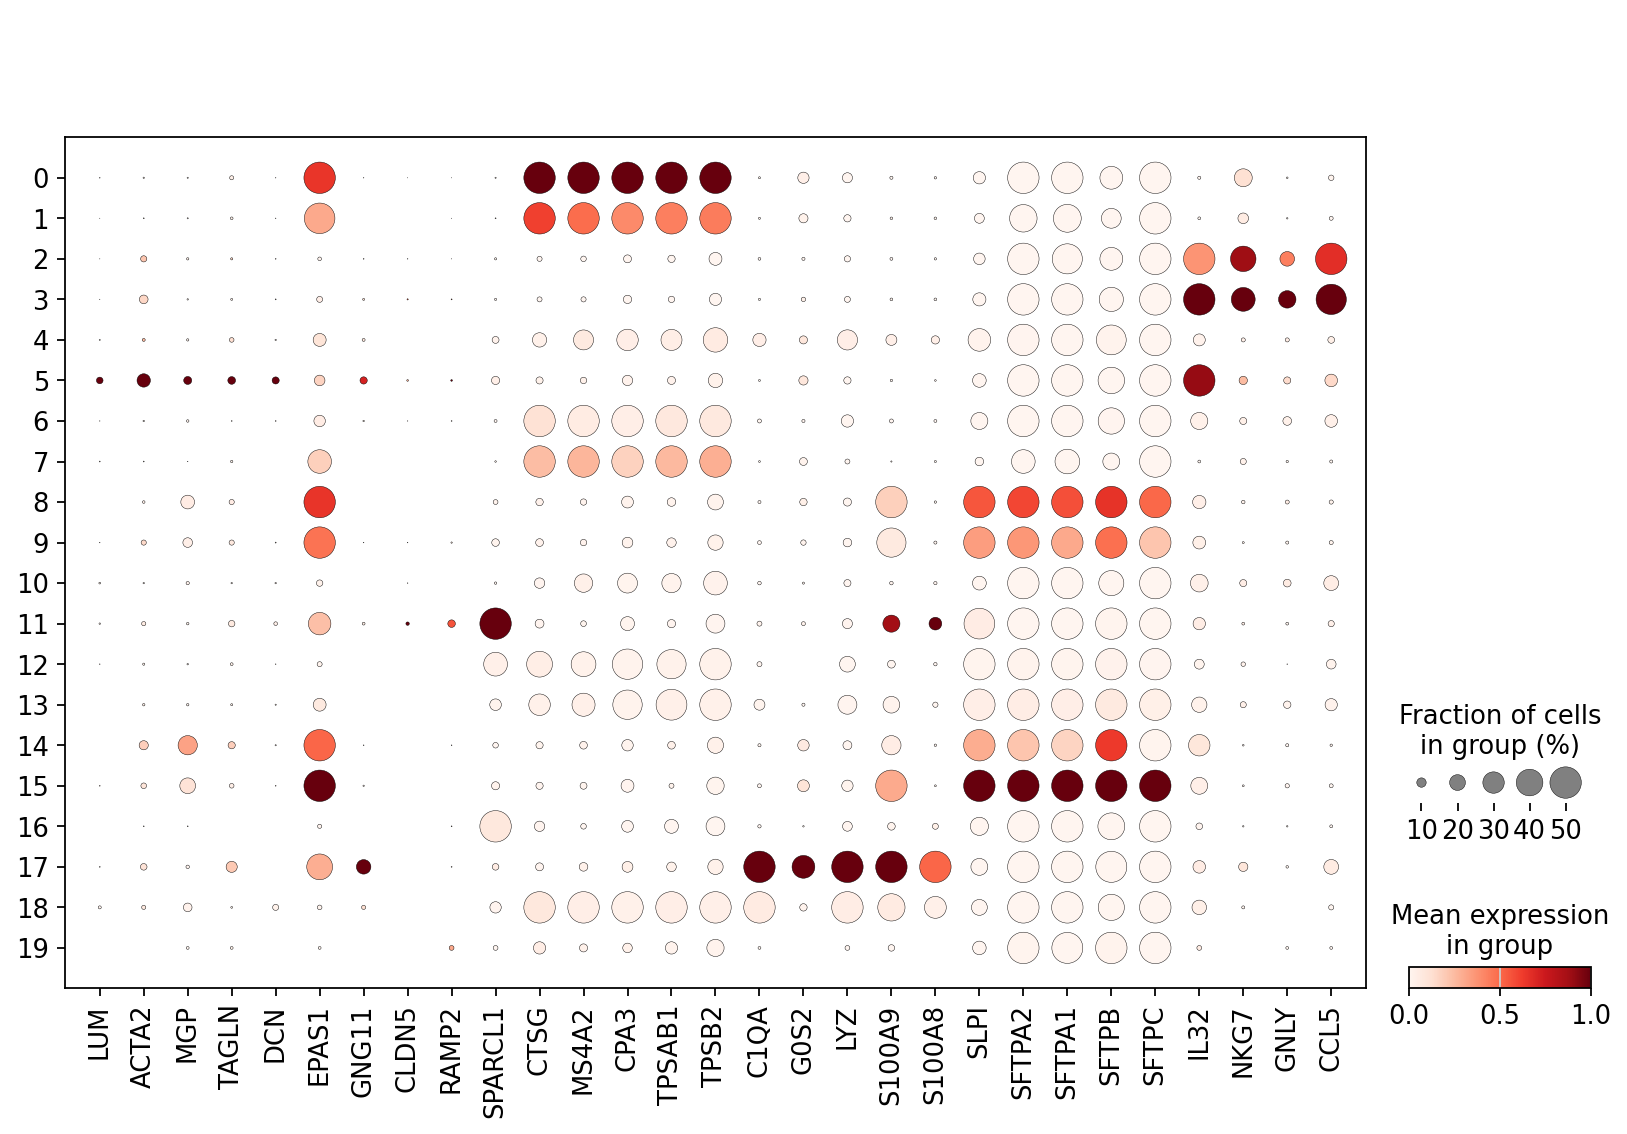

In [21]:
# Load your h5ad data
adata = sc.read_h5ad('GSE200972_RAW/cleaned_data/GSM6047623_P1_T_R_I.h5ad')

# Define your list of marker genes
marker_genes = [
    "LUM", "ACTA2", "MGP", "TAGLN", "DCN", "EPAS1", "GNG11",
    "CLDN5", "RAMP2", "SPARCL1", "IGLC3", "IGHG1", "IGHA1",
    "IGLC2", "IGKC", "CTSG", "MS4A2", "CPA3", "TPSAB1",
    "TPSB2", "C1QA", "G0S2", "LYZ", "S100A9", "S100A8",
    "SLPI", "SFTPA2", "SFTPA1", "SFTPB", "SFTPC", "TRAC",
    "IL32", "NKG7", "GNLY", "CCL5"
]

# Check which marker genes are present in your dataset
marker_genes_present = [gene for gene in marker_genes if gene in adata.var_names]
print(f"Marker genes present in the data: {marker_genes_present}")

# Ensure there are genes to plot
if not marker_genes_present:
    print("None of the marker genes are present in the data.")
else:
    # If you have cell type annotations, use them for grouping
    if 'cell_type' in adata.obs:
        groupby = 'cell_type'
    else:
        # If not, perform clustering to group the cells
        sc.pp.neighbors(adata)
        sc.tl.leiden(adata)
        groupby = 'leiden'

    # Create the dot plot
    sc.pl.dotplot(
        adata,
        var_names=marker_genes_present,
        groupby=groupby,
        standard_scale='var',  # Standardize gene expression for better visualization
        cmap='Reds',           # Color map for expression levels
        dot_max=0.5,           # Max size of dots
        save='dotplot.png'     # Save the plot as an image file
    )


Marker genes present in the data: ['LUM', 'ACTA2', 'MGP', 'TAGLN', 'DCN', 'EPAS1', 'GNG11', 'CLDN5', 'RAMP2', 'SPARCL1', 'CTSG', 'MS4A2', 'CPA3', 'TPSAB1', 'TPSB2', 'C1QA', 'G0S2', 'LYZ', 'S100A9', 'S100A8', 'SLPI', 'SFTPA2', 'SFTPA1', 'SFTPB', 'SFTPC', 'IL32', 'NKG7', 'GNLY', 'CCL5']


/home/fsadmin/miniconda3/envs/scf/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 19264 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


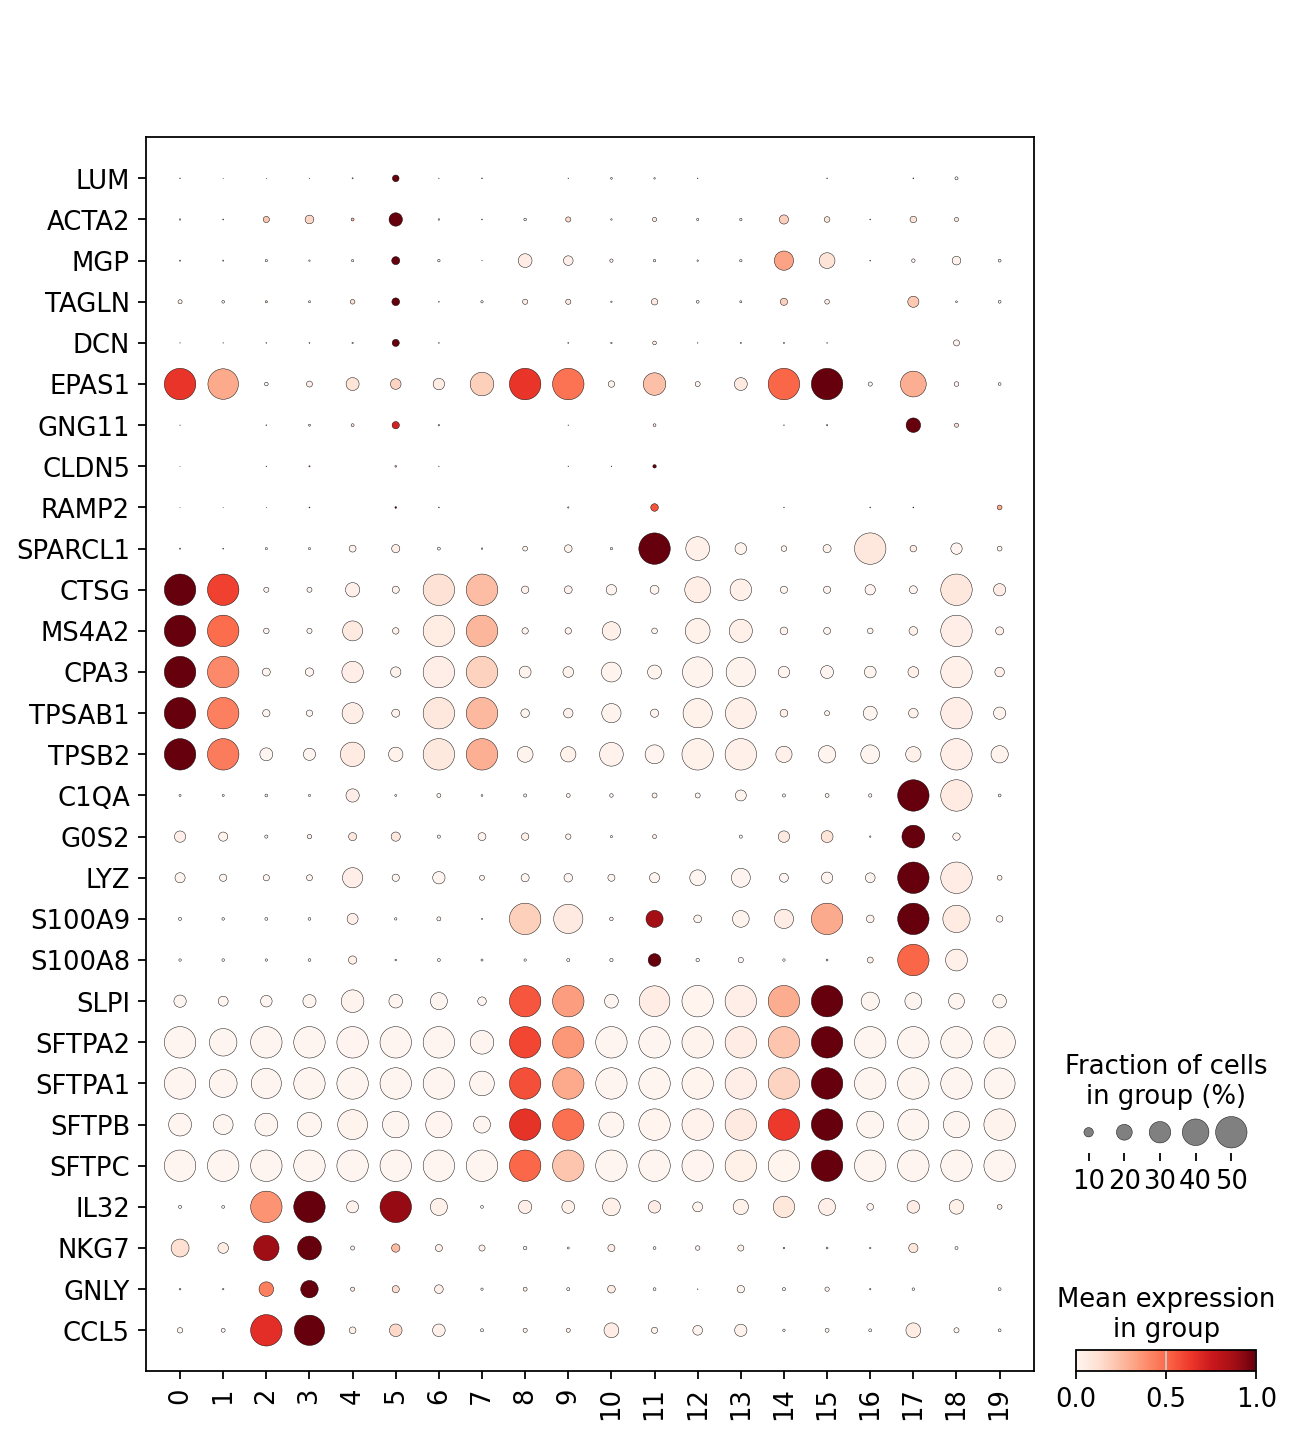

In [23]:
# Load your h5ad data
adata = sc.read_h5ad('GSE200972_RAW/cleaned_data/GSM6047623_P1_T_R_I.h5ad')

# Define your list of marker genes
marker_genes = [
    "LUM", "ACTA2", "MGP", "TAGLN", "DCN", "EPAS1", "GNG11",
    "CLDN5", "RAMP2", "SPARCL1", "IGLC3", "IGHG1", "IGHA1",
    "IGLC2", "IGKC", "CTSG", "MS4A2", "CPA3", "TPSAB1",
    "TPSB2", "C1QA", "G0S2", "LYZ", "S100A9", "S100A8",
    "SLPI", "SFTPA2", "SFTPA1", "SFTPB", "SFTPC", "TRAC",
    "IL32", "NKG7", "GNLY", "CCL5"
]

# Check which marker genes are present in your dataset
marker_genes_present = [gene for gene in marker_genes if gene in adata.var_names]
print(f"Marker genes present in the data: {marker_genes_present}")

# Ensure there are genes to plot
if not marker_genes_present:
    print("None of the marker genes are present in the data.")
else:
    # If you have cell type annotations, use them for grouping
    if 'cell_type' in adata.obs:
        groupby = 'cell_type'
    else:
        # If not, perform clustering to group the cells
        sc.pp.neighbors(adata)
        sc.tl.leiden(adata, resolution=1)
        groupby = 'leiden'

    # Create the dot plot with genes on the y-axis
    sc.pl.dotplot(
        adata,
        var_names=marker_genes_present,
        groupby=groupby,
        standard_scale='var',  # Standardize gene expression for better visualization
        cmap='Reds',           # Color map for expression levels
        dot_max=0.5,           # Max size of dots
        swap_axes=True,        # Swap axes to have genes on the y-axis
        save='dotplot_vertical_genes.png'  # Save the plot as an image file
    )


In [24]:
# Define the marker genes for each cell type
marker_genes_dict = {
    'Fibroblast': ['LUM', 'ACTA2', 'MGP', 'TAGLN', 'DCN'],
    'Endothelial': ['EPAS1', 'GNG11', 'CLDN5', 'RAMP2', 'SPARCL1'],
    'B_cell': ['IGLC3', 'IGHG1', 'IGHA1', 'IGLC2', 'IGKC'],
    'Mast_cell': ['CTSG', 'MS4A2', 'CPA3', 'TPSAB1', 'TPSB2'],
    'Myeloid_cell': ['C1QA', 'G0S2', 'LYZ', 'S100A9', 'S100A8'],
    'Epithelial': ['SLPI', 'SFTPA2', 'SFTPA1', 'SFTPB', 'SFTPC'],
    'T_NK_cell': ['TRAC', 'IL32', 'NKG7', 'GNLY', 'CCL5']
}

# Visualize expression of marker genes across clusters using a dot plot
sc.pl.dotplot(
    adata, 
    marker_genes_dict, 
    groupby='leiden',  # Assuming clusters are stored in adata.obs['leiden']
    standard_scale='var',  # Standardize gene expression
    swap_axes=True         # Swap axes to display genes on the y-axis
)

# Manually assign cell types to clusters based on marker expression
# Example:
adata.obs['cell_type'] = adata.obs['leiden'].map({
    '0': 'Fibroblast',
    '1': 'Endothelial',
    '2': 'B_cell',
    '3': 'Mast_cell',
    '4': 'Myeloid_cell',
    '5': 'Epithelial',
    '6': 'T_NK_cell'
})

KeyError: "Could not find keys '['IGHA1', 'IGHG1', 'IGKC', 'IGLC2', 'IGLC3', 'TRAC']' in columns of `adata.obs` or in adata.var_names."

In [ ]:
import os

def print_file_paths(folder_path):
    # Walk through the directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Join the root and file name to get the full path
            full_path = os.path.join(root, file)
            print(full_path)

# Replace this with your folder path
folder_path = "/home/fsadmin/Documents/forjupyter/users/Gourang/scFoundation/scfoundation_lung_cancer/GSE200972_RAW/cleaned_data"

print_file_paths(folder_path)
